In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import numpy.random as npr
import scipy.optimize as opt
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import sys
import glob

from scipy.special import logsumexp

# Summary

This notebook interprets and analyzes the posterior probabilities of de novo mutation produced by `run_de_novo_probabilities.sh`.

In [2]:
# Load in the data.

# results/posterior_mut_probs.tsv.gz is the posterior probabilities
# from the MCMC samples provided by the authors.
dat = pd.read_csv('results/posterior_mut_probs_subsample.tsv.gz', sep='\t', comment='#', compression='gzip')
dat['position'] = dat['position'].astype(np.int)
dat['rep'] = dat['rep'].astype(np.int)
dat.head(2)

,index,logprob,family,position,nodename,rep
0,4000000,-572.620340,F196,6791,m1c1_fblo,2953
1,4000001,-inf,F196,14573,m1c1_fblo,2953


In [3]:
# Calculate the posterior means across posterior samples.
pprobs = dat.groupby(['family', 'position', 'nodename']).apply(lambda x: np.exp(x['logprob']).mean())
pprobs_frame = pprobs.to_frame(name='pprob')
pprobs_frame['tissue'] = pprobs.index.to_frame()['nodename'].str.split('_', expand=True, n=1).iloc[:,1]
pprobs_frame.head(2)

pprob tissue
family position nodename              
F098   2377     m1_bl       0.0     bl
                m1_ch       0.0     ch

In [4]:
# For each heteroplasmic variant, calcualte the maximum posterior probability, across tissues.
pprobs_max = pprobs.groupby(level=[0,1]).max()
pprobs_max_frame = pprobs_frame.groupby(level=[0,1]).apply(lambda x: x.loc[x['pprob'].idxmax(),:])
tissues_max, pprobs_max_by_tissue = zip(*list(pprobs_max_frame.groupby('tissue')['pprob']))

In [5]:
# Preparing various things for the plot.
tissues_max_translated = {
    'bl':'adult blood',
    'ch':'adult cheek',
    'fblo':'early blood',
    'fbuc':'early cheek',
    'loo':'late oogenesis, meiotic arrest',
    'som':'pre-gastrulation somatic',
    'eoo_post': 'early oogenesis, post-oogonial divergence',
    'eoo_pre': 'early oogenesis, pre-oogonial divergence',}
labels = [tissues_max_translated[tis] for tis in tissues_max]

oplcolors = '''fblo #1f77b4   fixed
blo  #1f77b4   rate
fbuc #ff7f0e   fixed
buc  #ff7f0e   rate
som  #2ca02c   fixed
loo  #9467bd   rate
eoo_post  #d62728   fixed
eoo_pre  #ff8080   fixed'''
import cStringIO
oplcolorsio = cStringIO.StringIO(oplcolors)

colordat = pd.read_csv(oplcolorsio, sep='\s+', header=None, names=['tissue', 'color', 'type'])
color_dict = {row.tissue:row.color for row in colordat.itertuples(index=False)}
color_dict['bl'] = color_dict['blo']
color_dict['ch'] = color_dict['buc']
tissues_max_colors = [color_dict[tis] for tis in tissues_max]

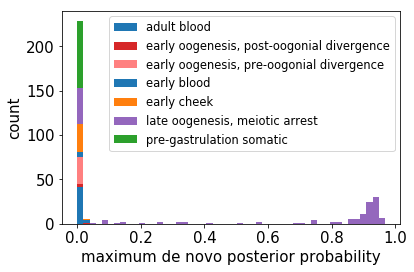

In [6]:
# Making the plot of posterior probabilities in the paper.
with mpl.rc_context({'font.size':15}):
    f, ax = plt.subplots(figsize=(6,4))
    ax.hist(pprobs_max_by_tissue, 50, stacked=True, label=labels, color=tissues_max_colors)
    with mpl.rc_context({'font.size':11.5}):
        ax.legend();
    ax.set_xlabel('maximum de novo posterior probability')
    ax.set_ylabel('count')
    f.tight_layout()

In [7]:
# Calculate the number of sites that are de novo according to OPL.
# This will vary a little with MCMC sampling noise.
is_opl_denovo = pprobs_frame.groupby(level=[0,1])['pprob'].apply(lambda x: np.any(x >= 0.8))
is_opl_denovo.sum()

87

See `germline_de_novo_regressions.ipynb` for regressions of number of *de novo* mutations against age.